In [24]:
import tensorflow.compat.v1 as tf
print("We're using TF", tf.__version__)
from matplotlib import animation, rc
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import HTML, clear_output, display_html
import numpy as np
import contextlib
import time
import io
import urllib
import base64
import keras
from tensorflow.python.keras import backend as K

We're using TF 2.13.0


In [25]:
def clear_and_display_figure(fig, sleep=.01):
    img_data = io.BytesIO()
    fig.savefig(img_data, format='jpeg')
    img_data.seek(0)
    uri = 'data:image/jpeg;base 64,' + urllib.request.quote(base64.b64encode(img_data.getbuffer()))
    img_data.close()
    clear_output(wait=True)
    display_html(HTML('<img src="' + uri + '">'))
    time.sleep(sleep)
    
# запись анимации для Колаба
class SimpleMovieWriter(object):
    """
    Usage example:
        anim = amimation.FuncAnimation(...)
        anim.save(None, writer=SimpleMovieWriter(sleep=.01))
    """
    def __init__(self, sleep=.1):
        self.sleep = sleep
        
    def setup(self, fig):
        self.fig = fig
    
    def grab_frame(self, **kwafgs):
        clear_and_display_figure(self.fig, self.sleep)
    
    @contextlib.contextmanager
    def saving(self, fig, *args, **kwargs):
        self.setup(fig)
        try:
            yield self
        finally:
            pass
        
def reset_tf_session():
    curr_session = tf.compat.v1.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
        
    # reset graph
    K.clear_session()
    # create new session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.compat.v1.Session(config=config)
    K.set_session(s)
    return s

In [26]:
# скидываем сессию
s = reset_tf_session()

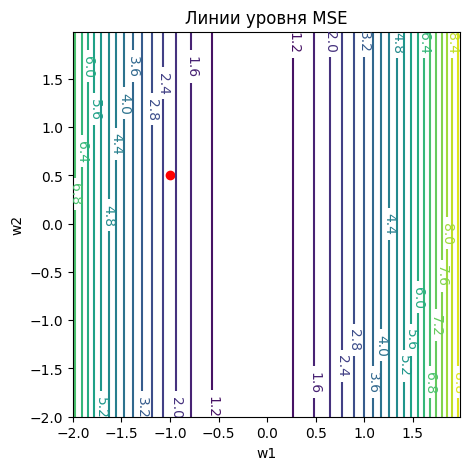

In [27]:
# генерируем простой датасет
np.random.seed(42)
N = 100
x = np.random.randn(N, 2)
w = np.array([[-1, .5]]).T
x[:, 0] *= 1 # признак x1 в x_scale рпз больше (создает долины в лоссе)
y = x @ w + np.random.randn(N, 1) * 0.2

# рисуем линии уровня лосса в пространстве весов
fig, ax = plt.subplots(figsize=(5, 5))
W1, W2 = np.meshgrid(np.arange(-2, 2, 0.01), np.arange(-2, 2, 0.01))
Z = np.mean((x.dot(np.vstack([W1.ravel(), W1.ravel()])) - y)**2, axis=0).reshape(W1.shape)
contour = ax.contour(W1, W2, Z, 20)
ax.scatter(*w, c='red')
plt.xlabel('w1')
plt.ylabel('w2')
plt.title(u'Линии уровня MSE')
ax.clabel(contour, inline=1, fontsize=10);

In [39]:
# визуализация шагов
def plot_gd(x_scale, lr, steps, optimizer='sgd'):
    # генерируем простой датасет
    np.random.seed(42)
    N = 100
    x = np.random.randn(N, 2)
    w = np.array([[-1, .5]]).T
    x[:, 0] *= 1 # признак x1 в x_scale рпз больше (создает долины в лоссе)
    y = x @ w + np.random.randn(N, 1) * 0.2
    
    # оптимизация в TF
    w_guess = tf.Variable([1.5, 1.5], dtype='float32')
    loss = tf.reduce_mean((tf.constant(x, tf.float32) * w_guess - tf.constant(y, tf.float32)) ** 2)
    if optimizer == 'sgd':
        step = tf.train.GradientDescentOptimizer(lr).minimize(loss, var_list=w_guess)
    elif optimizer == 'adam':
        step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=w_guess)
        
    # рисуем линии уровня лосса в пространстве весов
    fig, ax = plt.subplots(figsize=(5, 5))
    W1, W2 = np.meshgrid(np.arange(-2, 2, 0.01), np.arange(-2, 2, 0.01))
    Z = np.mean((x.dot(np.vstack([W1.ravel(), W1.ravel()])) - y)**2, axis=0).reshape(W1.shape)
    contour = ax.contour(W1, W2, Z, 20)
    ax.scatter(*w, c='red')
    plt.xlabel('w1')
    plt.ylabel('w2')
    plt.title(u'Линии уровня MSE')
    line, = ax.plot([], [], lw=2)
    
    s.run(tf.compat.v1.global_variables_initializer())
    
    # стартуем анимацию с пустой траекторией
    def init():
        line.set_data([], [])
        return (line, )
    
    trajectory = [s.run[w_guess]]
    
    # один шаг анимации (шаг backpropagation)
    def animate(i):
        s.run(step)
        trajectory.append(s.run(w_guess))
        line.set_data(*zip(*trajectory))
        return (line, )
    
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=steps, interval=20, blit=True)
    
    anim.save(None, writer=SimpleMovieWriter(.0001))

# Простой SGD
У наивного SGD есть проблемы, он плохо сходится когда производные по разным весам слишком разные по масштабу

In [40]:
plot_gd(x_scale=1.0, lr=0.1, steps=25)

RuntimeError: `loss` passed to Optimizer.compute_gradients should be a function when eager execution is enabled.